In [1]:
#you'll need to install my "sportsref" library, which provides a way to scrape baseball-reference easier
#uncomment and run the line below to install
# !pip install git+https://github.com/double-dose-larry/sportsref.git

In [2]:
import pandas as pd
import requests as r
import json
from sportsref.baseball import Franchise
from matplotlib.patches import Ellipse, Polygon

In [3]:
def get_standings(year):
    "scrape the standings data from statsapi.mlb.com"
    api_url = f"https://statsapi.mlb.com/api/v1/standings?leagueId=103,104&season={year}&standingsTypes=regularSeason,springTraining&hydrate=division,conference,sport,league,team"
    data_json = r.get(api_url).json()
    dfs = []
    for record in data_json["records"]:
        for team in record["teamRecords"]:
            tm = {}
            tm["abbr"] = team["team"]["abbreviation"]
            tm["season"] = record["league"]["season"]
            tm["standings_type"] = record["standingsType"]
            tm["team"] = team["team"]["name"]
            tm["division"] = team["team"]["division"]["name"]
            tm["wins"] = int(team["wins"])
            tm["losses"] = int(team["losses"])
            tm["winning_pct"] = float(team["winningPercentage"])
            dfs.append(tm)
    df = pd.DataFrame(dfs)
    return df

In [4]:
#run the scrape, this might 3 minutes or so

In [5]:
%%time
df = pd.concat([ get_standings(yr) for yr in range(2006,2021) ])

CPU times: user 361 ms, sys: 176 ms, total: 536 ms
Wall time: 2min 6s


In [6]:
def get_playoffs(team, season):
    "scrape baseball-reference.com for the playoff results, this might take about 5 min"
    return_df = Franchise(team).hist().get_df('franchise_years')
    rtn = return_df.query(f"Year == {season}")["Playoffs"].astype(str).iloc[0].replace("\xa0", " ")
    return rtn

In [8]:
plot_df = df.pivot(index=["abbr", "team","season"], columns="standings_type", values="winning_pct").reset_index()

In [9]:
plot_df["diff"] = plot_df.springTraining - plot_df.regularSeason

In [ ]:
# below might take 5 min or so

In [ ]:
%%time
plot_df["playoffs"] = plot_df.apply(lambda row: get_playoffs(row.team, row.season), axis=1)

In [12]:
# you might want to save the data in a file

# df.to_pickle("data.pkl")
# df = pd.read_pickle('data.pkl')

In [13]:
#for plotting
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from scipy.stats import linregress

In [14]:
plt.xkcd()

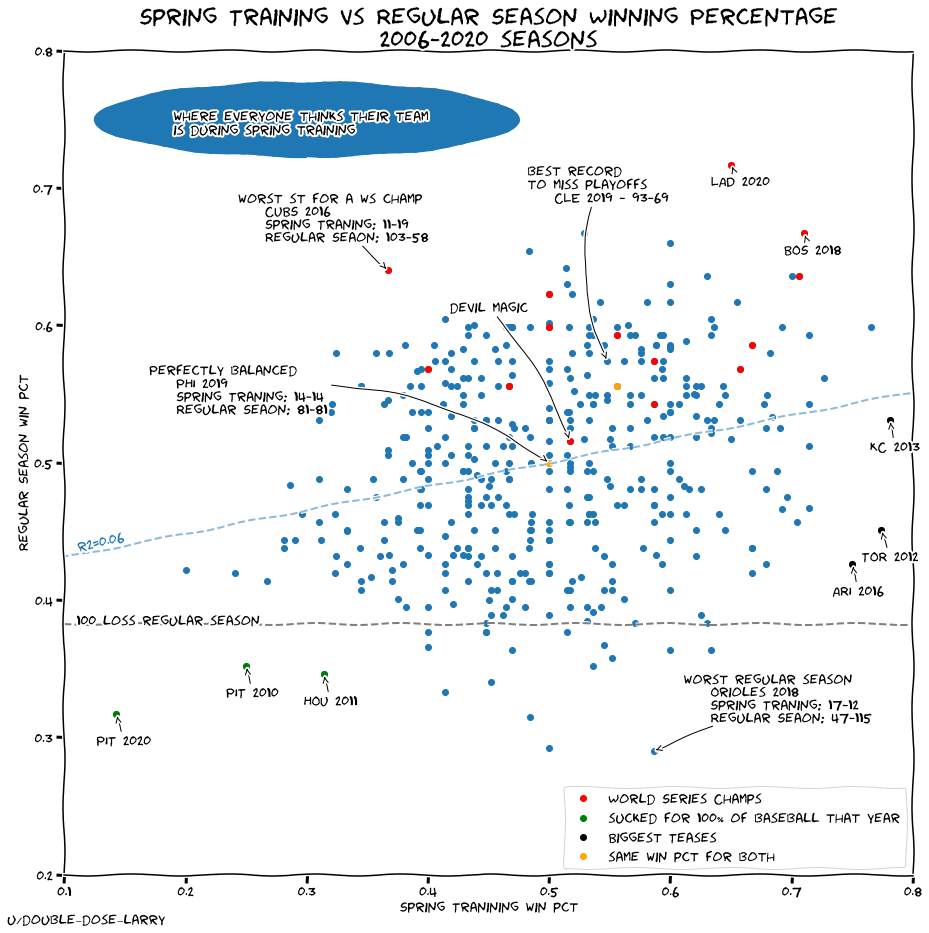

In [15]:
f, ax = plt.subplots(figsize=(13,13))

y='regularSeason'
x='springTraining'

# plot regression line

slope, intercept, r_value, p_value, std_err = linregress(plot_df[x], plot_df[y])
x1=np.linspace(0,1,50)
y1=slope*x1+intercept
ax.plot(x1,y1,alpha=0.5, ls="--")
r2 = r_value ** 2
ax.annotate(f"r2={r2:.2f}", (.11,.436),
           rotation=13,
           color="C0",
           alpha=1)


ax.scatter(
    data=plot_df,
    x=x,
    y=y,
    label=''
)

ws = plot_df[plot_df.playoffs.str.contains('Won WS')]
ax.scatter(ws[x], ws[y], color='r', label="World Series Champs")
# ax.axhline(low[x].mean(), ls='--', c='r')

losers = plot_df.query("springTraining < .39 and regularSeason < .39")
ax.scatter(losers[x], losers[y], color='green', label="sucked for 100% of baseball that year")
# annotate losers
text = [
    ax.annotate(
        f"{ts.abbr} {ts.season}",
        (ts.springTraining, ts.regularSeason),
        xytext = (-20,-30),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->")
    )
    for ts in losers.itertuples()
]


# biggest teases
teases = plot_df.query("regularSeason < .55 and springTraining > .74")
ax.scatter(teases[x], teases[y], color = 'k', label="Biggest Teases")
text = [
    ax.annotate(
        f"{ts.abbr} {ts.season}",
        (ts.springTraining, ts.regularSeason),
        xytext = (-20,-30),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->")
    )
    for ts in teases.itertuples()
]

# really good
good = plot_df.query("regularSeason > .64 and springTraining > .64")
# ax.scatter(teases[x], teases[y], color = 'orange', label="really good")
text = [
    ax.annotate(
        f"{ts.abbr} {ts.season}",
        (ts.springTraining, ts.regularSeason),
        xytext = (-20,-20),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->",
                     connectionstyle="arc3,rad=-0.05")
    )
    for ts in good.itertuples()
]


ax.axhline(62/162, lw=2, ls="--", c='k', alpha=.5)
ax.annotate("100 loss regular season", (.11, 62/162))

# 2016 cubs
text = ax.annotate(
    """worst st for a ws champ
    CUBS 2016
    Spring Traning: 11-19
    Regular Seaon: 103-58""",
    (.367, .64),
    xytext = (-150, 30),
    textcoords="offset pixels",
    arrowprops=dict(arrowstyle="->")
)

# 2018 orioless
text = ax.annotate(
    """worst regular season
    Orioles 2018
    Spring Traning: 17-12
    Regular Seaon: 47-115""",
    (.586, .29),
    xytext = (30, 30),
    textcoords="offset pixels",
    arrowprops=dict(arrowstyle="->")
)


# add joke about season hopes
ax.add_patch(Ellipse((0.3,0.75), 0.35, 0.055, 0, fill=True, ls="--", lw=3))
ax.annotate("where everyone thinks their team\nis during spring training",
            (.19,.74))

# best regular season record to miss the playoffs
best_missed_playoff = plot_df[plot_df.playoffs == 'nan'].sort_values('regularSeason', ascending=False).iloc[0]
text = ax.annotate(
    f"""best record\nto miss playoffs
    {best_missed_playoff.abbr} {best_missed_playoff.season} - 93-69""",
    (best_missed_playoff.springTraining, best_missed_playoff.regularSeason),
        xytext = (-80,160),
        textcoords="offset pixels",
        arrowprops=dict(
                    arrowstyle="->",
                    connectionstyle="arc3,rad=0.2")
)

# devil magic
devil_magic = plot_df[plot_df.playoffs.str.contains("Won WS")].sort_values('regularSeason', ascending=True).iloc[0]
text = ax.annotate(
    f"""devil magic""",
    (devil_magic.springTraining, devil_magic.regularSeason),
        xytext = (-120,130),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->",
                     connectionstyle="arc3,rad=-0.1")
)

# perfectly balanced
balance = plot_df[plot_df["diff"] == 0]
ax.scatter(balance.springTraining, balance.regularSeason, label = "same win pct for both", color="orange")

# phillies 2019
ax.annotate(
    f"""Perfectly balanced
    PHI 2019
    Spring Traning: 14-14
    Regular Seaon: 81-81""",
    (balance.iloc[1].springTraining, balance.iloc[1].regularSeason),
        xytext = (-400,50),
        textcoords="offset pixels",
        arrowprops=dict(
                     arrowstyle="->",
                     connectionstyle="arc3,rad=-0.2")
)



# adjust_text(bad_text, limit=10)
plt.legend(loc="lower right")
plt.title("Spring Training vs Regular Season Winning Percentage\n2006-2020 seasons", size=24)
plt.ylabel("Regular Season win pct")
plt.xlabel("Spring Tranining win pct")
plt.xlim(0.1,0.8)
plt.ylim(0.2,0.8)
plt.tight_layout()
#sign the damn thing
plt.figtext(0.005,.005,"u/double_dose_larry")
plt.savefig("st_vs_rs.png")